In [44]:
# Uncomment to install new packages
#import sys
#!{sys.executable} -m pip install <package_name>

MIT License

Copyright (c) 2021 Fernando Soler-Toscano

# Information Structures in Lotka-Volterra (LV) cooperative systems

To increase computational efficiency, some shortcuts have been followed in the definition of functions that are only valid in cooperative systems. 

The equation modelling the dynamics of each $u_i$ in LV cooperative systems is:
\begin{equation}
    {\dot{u}_{i}=u_{i}\left(\alpha_{i}-u_{i}+\sum_{j\neq i}^{n}\gamma_{ij}u_{j}\right)}\label{eq:LV-1-2}
\end{equation}
where $\alpha_{i}$ are the growth rates and $\gamma_{ij}$ the links between nodes. 

In cooperative systems, all $\gamma_{ij}$ values are possitive. Matrix $\Gamma$ containing the $\gamma_{ij}$ values has $0$s in the diagonal, and the sum of $\Gamma$ plus the identity matrix is diagonally dominant. 

## Building the Information Structure (IS) and computing the IS measures

First, some functions to build the IS starting from the $\alpha_i$ values (*alphas*) and $\Gamma$ matrix (*gammas*). The IS can be visualized as a directed graph. Informational measures on the IS are defined.

In [1]:
import numpy as np
import warnings
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import networkx as nx
import igraph as ig
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')

# FUNCTIONS TO BUILD THE INFORMATION STRUCTURE
    
# Given alpha and gamma values, this function returns the stable points of the IS
def ISpoints(alphas, gammas):
    siz = len(alphas)
    isP = [[0 for i in range(siz)]]
    m = matrix(gammas)-identity_matrix(siz)
    a = matrix([alphas])
    for s in Subsets(range(siz))[1:]:
        l = list(s)
        sol = list((m[l,l]).solve_right(vector(-transpose(a)[l])))
        if(min(sol)>0):
            newP = [0 for i in range(siz)]
            for ne in range(len(l)):
                newP[l[ne]] = sol[ne]
            isP.append(newP)
    return isP

# Given alpha and gamma values, this function returns the global stable point in cooperative
# systems. It is the last point returned by ISPoints(alphas,gammas). It won't be valid for
# competitive systems. 
def ISglobalPointCoop(alphas, gammas):
    return ISpoints(alphas, gammas)[-1]


# This function transform an IS point into a list of 0s and 1s to be shown in graph nodes.
def pointIS2node(solIS):
    return ''.join(['1' if i>0 else '0' for i in solIS])

# Given an IS node, this function returns its level (number of values > 0) to determine its 
# position in the IS
def levelISnode(solIS):
    return sum([1 if i>0 else 0 for i in solIS])

# This function determines if the nodes with a value greater than 0 in sn1 is a subset of the
# nodes >0 in sn2. In that case, a solution exists from sn1 to sn2 that will be represented
# by an edge in the graph. 
def pointSubset(sn1,sn2):
    b = True
    for i in range(len(sn1)):
        b = b and ((sn1[i]==0) or (sn2[i]!=0))
    return b

# Given the IS points, this function builds a graph representing it. The output is a list with
# the graph and node labels. 
def igraphIScoop(isp):
    g = ig.Graph(directed=True)
    g.add_vertices(range(len(isp)))
    labels = [pointIS2node(s) for s in isp]
    for i in range(len(isp)-1):
        levi = levelISnode(isp[i]) 
        j=i
        while(j<len(isp) and levelISnode(isp[j])<=levi+1):
            if(levelISnode(isp[j])==levi+1 and pointSubset(isp[i],isp[j])):
                g.add_edges([(i,j)])
            j+=1
    return [g, labels]

# MEASURING THE IS

# This function returns a list with NoEL and Frondosity values. 
def NoELandFrond(isp):
    gL = levelISnode(isp[-1])
    return [1+gL, len(isp)/2^gL]

# This function returns the Criticality value of the global stable point (GASS) of the IS
def criticality(isp,alphas,gammas):
    if(len(isp)==1):
        return 0
    m = identity_matrix(len(alphas))-matrix(gammas)
    glob = matrix(isp[-1]).transpose()
    v = -matrix(alphas).transpose() + (m*glob) + glob
    c = min(map(abs,(v/sqrt(sum([t^2 for t in v.list()]))).list()))
    return c

# Synchronicity is a measure on the evolution of the IS in time. This function returns 1 in 
# case that all nodes of the system are synchronized in the given IS, 0 otherwise. To compute
# Synchronicity, the mean value in time will be calculated. 
def synchronicity(isp):
    if(min(isp[-1])>0 or max(isp[-1])==0):
        return 1
    else:
        return 0

# Given an IS and alpha values, this function returns the points in the IS that result from 
# cooperation (cooperative points).
def coopPoints(isp,alphas):
    cP = []
    for a in range(len(alphas)):
        if(isp[-1][a]>0 and alphas[a]<=0):
            for p in range(len(isp)):
                if(isp[p][a]>0):
                    found = False
                    t = 0
                    while(t<len(cP) and not(found)):
                        found = pointSubset(cP[t],isp[p])
                        t += 1
                    if(not(found)):
                        cP.append(isp[p])
    return cP
    
                                                                        
# This functions returns the cooperation values, with the following structure: 
# [HighestCooperationLevel, CoopValA, CoopValB, CoopValC]
def coopVector(isp,alphas):
    coopP = coopPoints(isp,alphas)
    coopL = [levelISnode(s) for s in coopP]
    hl = max([0]+coopL)
    ca = sum(coopL)-len(coopL)
    cb = 0
    cc = 0
    for i in range(len(alphas)):
        if(alphas[i]<= 0 and isp[-1][i]>0):
            found = False
            j = 0
            while(not(found) and j<len(coopP)):
                found = (coopP[j][i]>0)
                j += 1
            ln = levelISnode(coopP[j-1])-1
            cb += ln
            cc += 2^ln
    return [hl, ca, cb, cc]
    
# A function to return all IS measures
# [NoEL, Frond, Critic, HighestCooperationLevel, CoopValA, CoopValB, CoopValC, Synchro]
def allISmeasures(alphas,gammas):
    isp = ISpoints(alphas, gammas)
    nf  = NoELandFrond(isp)
    cr  = criticality(isp,alphas,gammas)
    cv  = coopVector(isp,alphas)
    sy  = synchronicity(isp)
    return nf+[cr]+cv+[sy]

## Examples

### IS construction

Example of IS construction with given $\alpha_i$ and $\gamma_{i,j}$ values.

In [2]:
# Connectivity matrix
gammasEx = [[0,0.1,0.2,0.3],[0.3,0,0.4,0.1],[0.15,0.25,0,0.1],[0.1,0.2,0.3,0]]
# Alpha values
alphasEx = [-.1,-.1,3,-.2]
isp = ISpoints(alphasEx, gammasEx)  # Build the IS
matrix(isp)                         # Points in the IS

[0.000000000000000 0.000000000000000 0.000000000000000 0.000000000000000]
[0.000000000000000 0.000000000000000  3.00000000000000 0.000000000000000]
[0.515463917525773 0.000000000000000  3.07731958762887 0.000000000000000]
[0.000000000000000  1.22222222222222  3.30555555555556 0.000000000000000]
[0.000000000000000 0.000000000000000  3.07216494845361 0.721649484536082]
[0.750915750915751  1.52258852258852  3.49328449328449 0.000000000000000]
[0.792621576299609 0.000000000000000  3.20290665176076 0.840134153158189]
[0.000000000000000  1.39604553624925  3.46075494307969  1.11743559017376]
[ 1.30825741992360  1.97531589773729  3.83779018513077  1.47722597707905]

Displaying the IS graph:

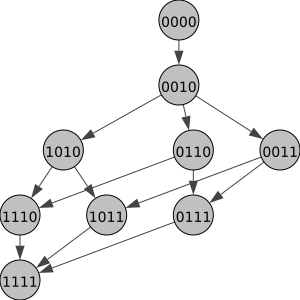

In [3]:
G = igraphIScoop(isp)                          # Get the graph (G[0]) and node labels (G[1])
layout= G[0].layout("tree")                    # Set node positions to be displayes as a tree
ig.plot(G[0],layout=layout,vertex_label=G[1],  # Plot the IS graph
        vertex_color='#C0C0C0',vertex_size=40,
        margins=60,bbox=(300,300))

Look at all IS measures in this example:

In [4]:
NoELandFrond(isp)

[5, 9/16]

In [5]:
synchronicity(isp)

1

In [6]:
coopPoints(isp,alphasEx)

[[0.515463917525773, 0, 3.07731958762887, 0],
 [0, 1.22222222222222, 3.30555555555556, 0],
 [0, 0, 3.07216494845361, 0.721649484536082]]

In [7]:
criticality(isp,alphasEx,gammasEx)

0.275656431044271

In [8]:
coopVector(isp,alphasEx)

[2, 3, 3, 6]

### Interactive IS

Running the code below produces an IS that changes when modifying the $\alpha_i$ parameters. Node values and all IS measures are shown. 

In [9]:
#%matplotlib inline
import matplotlib.pyplot as plt

def demoGIS(a1,a2,a3,a4):
    gmm = [[0,0.2,0.2,0.2],[0.2,0,0.2,0.2],[0.2,0.2,0,0.2],[0.2,0.2,0.2,0]]
    alp = [a1,a2,a3,a4]
    isp = ISpoints(alp, gmm)
    G = igraphIScoop(isp)
    print("".join(["IS points (",str(len(isp)),"):"]))
    print(matrix(isp).n(5))
    nf = NoELandFrond(isp)
    print("\nNoEL:\t\t\t",nf[0])
    print("Frondosity:\t\t",nf[1].n(5))
    print("Criticality:\t\t",criticality(isp,alp,gmm).n(5))
    cv = coopVector(isp,alp)
    print("Highest coop. level:\t",cv[0])
    print("Coop. values (A,B,C):\t",(cv[1],cv[2],cv[3]))
    layout= G[0].layout("tree")
    return ig.plot(G[0],layout=layout,vertex_label=G[1],
            vertex_color='#C0C0C0',vertex_size=40,bbox=(400,300))


interact(demoGIS, 
         a1=FloatSlider(min=-3, max=3,value=0.7),
         a2=FloatSlider(min=-3, max=3,value=1.5),
         a3=FloatSlider(min=-3, max=3,value=-0.5),
         a4=FloatSlider(min=-3, max=3,value=-0.2))

interactive(children=(FloatSlider(value=0.7, description='a1', max=3.0, min=-3.0), FloatSlider(value=1.5, desc…

<function demoGIS at 0x7fa5e6dd80d0>

## Computing the mean and standard deviation on IS measures

The code below shows an example of the computation of the evolution of IS in time and the mean and standard deviation of IS measures. The input is the connectivity matrix (*gammasEx*) with $\gamma_{ij}$ parameters and the timeseries of $\gamma_i$ values. 

In [10]:
## Generates random data to test the measures

import random as rnd
rnd.seed(234)
alphasEx = [[10*(rnd.random()-0.5) for i in range(7)] for t in range(295)]       # Random alpha_i values
gammasEx = [[rnd.random()/7 if i!=j else 0 for i in range(7)] for j in range(7)] # Connectivity

In [11]:
# IS measures calculation for all timepoints
isM = matrix([allISmeasures(alphasEx[n],gammasEx) for n in range(len(alphasEx))]).transpose()

In [12]:
# Mean and standard deviation of the measures
print("Mean NoEL:\t\t %.3f" % mean(isM[0]))
print("Stdev. NoEL:\t\t %.3f\n" % std(list(isM[0])))
print("Mean Frondosity:\t %.3f" % mean(isM[1]))
print("Stdev. Frondosity:\t %.3f\n" % std(list(isM[1])))
print("Median Criticality:\t %.3f" % median(isM[2]))
print("Stdev. Criticality:\t %.3f\n" % std(list(isM[2])))
print("Mean Highest Coop L:\t %.3f" % mean(isM[3]))
print("Stdev. Highest Coop L:\t %.3f\n" % std(list(isM[3])))
print("Mean Coop Value A:\t %.3f" % mean(isM[4]))
print("Stdev. Coop Value A:\t %.3f\n" % std(list(isM[4])))
print("Mean Coop Value B:\t %.3f" % mean(isM[5]))
print("Stdev. Coop Value B:\t %.3f\n" % std(list(isM[5])))
print("Mean Coop Value C:\t %.3f" % mean(isM[6]))
print("Stdev. Coop Value C:\t %.3f\n" % std(list(isM[6])))
print("Synchronicity:\t\t %.3f" % mean(isM[7]))

Mean NoEL:		 4.902
Stdev. NoEL:		 1.353

Mean Frondosity:	 0.886
Stdev. Frondosity:	 0.182

Median Criticality:	 0.061
Stdev. Criticality:	 0.061

Mean Highest Coop L:	 1.149
Stdev. Highest Coop L:	 1.704

Mean Coop Value A:	 1.766
Stdev. Coop Value A:	 3.814

Mean Coop Value B:	 0.922
Stdev. Coop Value B:	 1.768

Mean Coop Value C:	 3.105
Stdev. Coop Value C:	 11.416

Synchronicity:		 0.020


## Results for post-comatose patients

Comparison of IS for healthy controls (HC), patients in minimally conscious state (MCS) and unresponsive wakefulness state (UWS).

In [13]:
import pandas as pd

# Importing the table with IS measures
df = pd.read_csv('LiegeParisISMeasuresDOC.csv')

In [14]:
from scipy.stats import mannwhitneyu

# Show the values of Wilcoxon tests comparing the groups for any measure. 
def WilcoxonTest(measure):
    hcA  = df[df.Class == 'HC'][measure].values
    hcL  = df[df.Class == 'HC'][df.Dataset == 'Liege'][measure].values
    hcP  = df[df.Class == 'HC'][df.Dataset == 'Paris'][measure].values
    mcsA = df[df.Class == 'MCS'][measure].values
    mcsL = df[df.Class == 'MCS'][df.Dataset == 'Liege'][measure].values
    mcsP = df[df.Class == 'MCS'][df.Dataset == 'Paris'][measure].values
    uwsA = df[df.Class == 'UWS'][measure].values
    uwsL = df[df.Class == 'UWS'][df.Dataset == 'Liege'][measure].values
    uwsP = df[df.Class == 'UWS'][df.Dataset == 'Paris'][measure].values
    print(measure)
    print(" * HC/DOC")
    print("   - All:    %s" % mannwhitneyu(list(hcA), list(mcsA)+list(uwsA),alternative="two-sided",use_continuity=False)[1])
    print("   - Liege:  %s" % mannwhitneyu(list(hcL), list(mcsL)+list(uwsL),alternative="two-sided",use_continuity=False)[1])
    print("   - Paris:  %s" % mannwhitneyu(list(hcP), list(mcsP)+list(uwsP),alternative="two-sided",use_continuity=False)[1])
    print(" * MCS/UWS")
    print("   - All:    %s" % mannwhitneyu(list(mcsA), list(uwsA),alternative="two-sided",use_continuity=False)[1])
    print("   - Liege:  %s" % mannwhitneyu(list(mcsL), list(uwsL),alternative="two-sided",use_continuity=False)[1])
    print("   - Paris:  %s" % mannwhitneyu(list(mcsP), list(uwsP),alternative="two-sided",use_continuity=False)[1])
    print()

# Example for NoEL:
WilcoxonTest("Mean NoEL")
WilcoxonTest("Std. dev. NoEL")

Mean NoEL
 * HC/DOC
   - All:    3.69891701701486e-11
   - Liege:  1.3494947906434382e-07
   - Paris:  0.0002517002564604138
 * MCS/UWS
   - All:    2.4345745248577562e-05
   - Liege:  0.003331272038601022
   - Paris:  0.002082124771769803

Std. dev. NoEL
 * HC/DOC
   - All:    4.27421585901461e-09
   - Liege:  2.643965820358528e-06
   - Paris:  0.0023172557376137507
 * MCS/UWS
   - All:    4.101222697881177e-05
   - Liege:  0.0037501252485618625
   - Paris:  0.0036794155751496823



Box-plots comparing all measures in the three groups. 

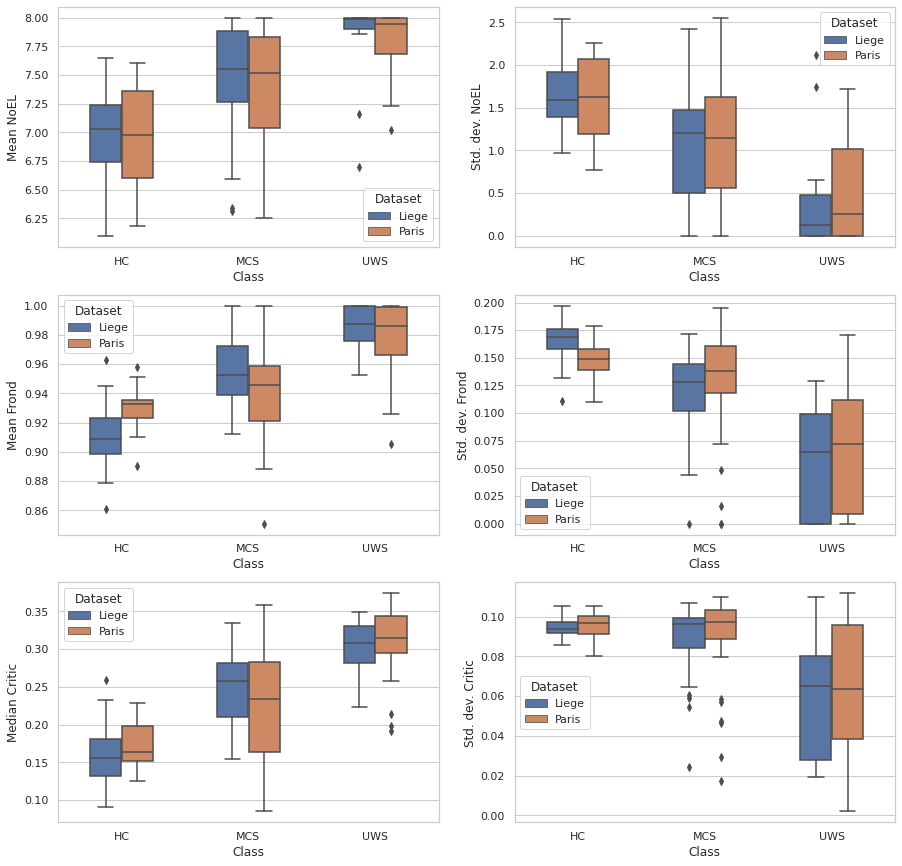

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=False)
sns.boxplot(ax=axes[0, 0],x="Class", y="Mean NoEL", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[0, 1],x="Class", y="Std. dev. NoEL", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[1, 0],x="Class", y="Mean Frond", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[1, 1],x="Class", y="Std. dev. Frond", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[2, 0],x="Class", y="Median Critic", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[2, 1],x="Class", y="Std. dev. Critic", hue="Dataset", data=df, width=0.5)
plt.show()

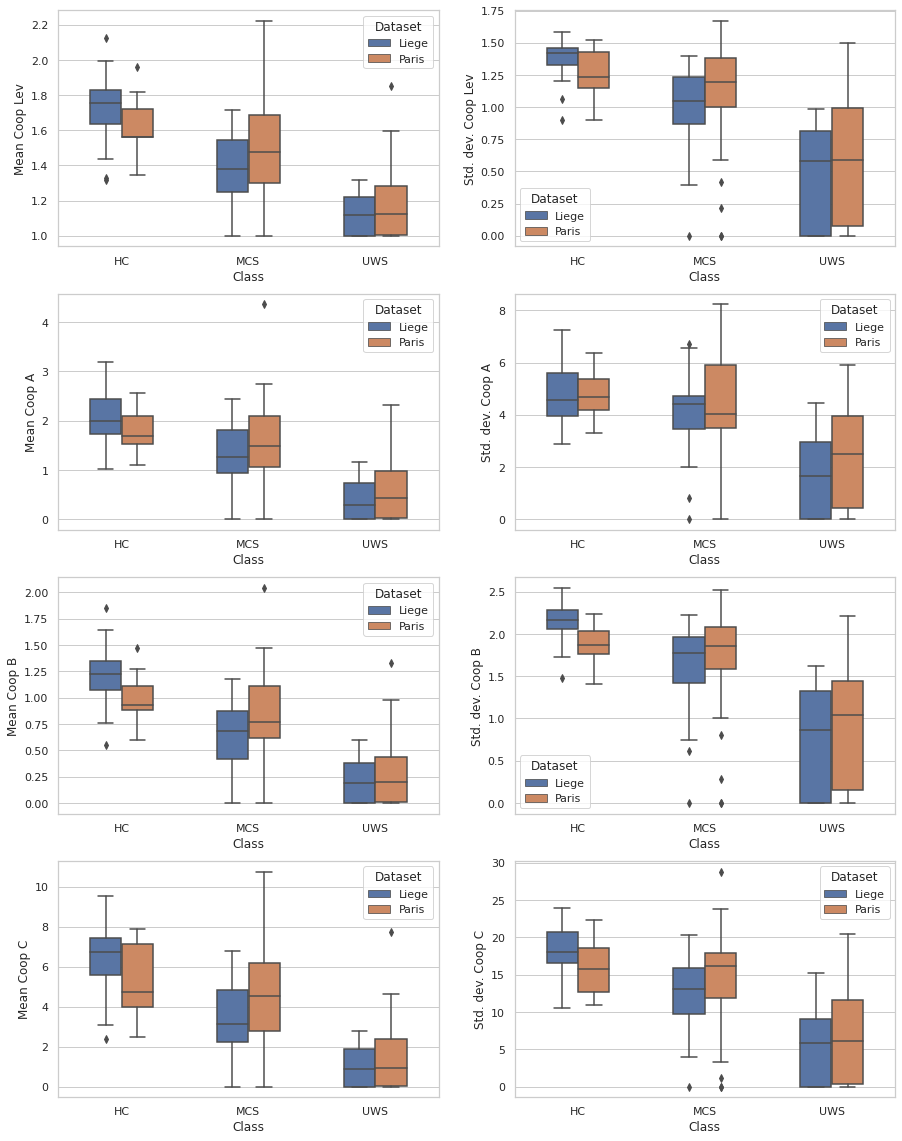

In [16]:

fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharey=False)
sns.boxplot(ax=axes[0, 0],x="Class", y="Mean Coop Lev", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[0, 1],x="Class", y="Std. dev. Coop Lev", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[1, 0],x="Class", y="Mean Coop A", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[1, 1],x="Class", y="Std. dev. Coop A", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[2, 0],x="Class", y="Mean Coop B", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[2, 1],x="Class", y="Std. dev. Coop B", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[3, 0],x="Class", y="Mean Coop C", hue="Dataset", data=df, width=0.5)
sns.boxplot(ax=axes[3, 1],x="Class", y="Std. dev. Coop C", hue="Dataset", data=df, width=0.5)

plt.show()

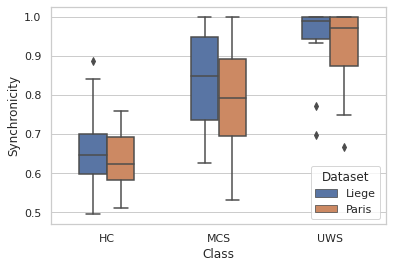

In [17]:
sns.boxplot(x="Class", y="Synchronicity", hue="Dataset", data=df, width=0.5)
plt.show()